No handles with labels found to put in legend.
No handles with labels found to put in legend.


          净值日期    单位净值    累计净值  日增长率  申购状态  赎回状态 分红送配
0   2018-04-24  1.0000  1.0000   NaN  开放申购  开放赎回  nan
1   2018-04-25  1.0000  1.0000  0.00  开放申购  开放赎回  nan
2   2018-04-26  0.9833  0.9833 -1.67  开放申购  开放赎回  nan
3   2018-04-27  0.9851  0.9851  0.18  开放申购  开放赎回  nan
4   2018-05-02  0.9840  0.9840 -0.11  开放申购  开放赎回  nan
5   2018-05-03  0.9931  0.9931  0.92  开放申购  开放赎回  nan
6   2018-05-04  0.9932  0.9932  0.01  开放申购  开放赎回  nan
7   2018-05-07  1.0109  1.0109  1.78  开放申购  开放赎回  nan
8   2018-05-08  1.0145  1.0145  0.36  开放申购  开放赎回  nan
9   2018-05-09  1.0125  1.0125 -0.20  开放申购  开放赎回  nan
10  2018-05-10  1.0143  1.0143  0.18  开放申购  开放赎回  nan
11  2018-05-11  1.0065  1.0065 -0.77  开放申购  开放赎回  nan
12  2018-05-14  1.0031  1.0031 -0.34  开放申购  开放赎回  nan
13  2018-05-15  1.0118  1.0118  0.87  开放申购  开放赎回  nan
14  2018-05-16  1.0092  1.0092 -0.26  开放申购  开放赎回  nan
15  2018-05-17  1.0047  1.0047 -0.45  开放申购  开放赎回  nan
16  2018-05-18  1.0083  1.0083  0.36  开放申购  开放赎回  nan
17  2018-05-21  1.0206  1.02

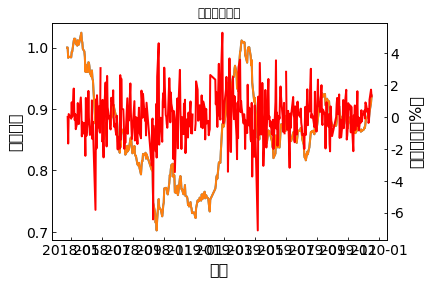

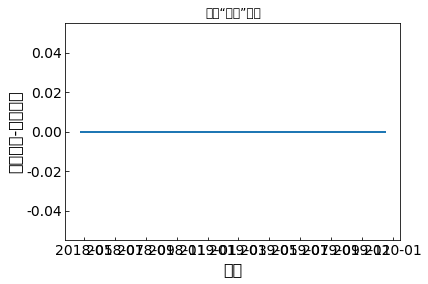

日增长率缺失： 4
日增长率为正的天数： 193
日增长率为负（包含0）的天数： 210


In [233]:
# 导入需要的模块
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False

# 抓取网页
def get_url(url, params=None, proxies=None):
    rsp = requests.get(url, params=params, proxies=proxies)
    rsp.raise_for_status()
    return rsp.text

# 从网页抓取数据
def get_fund_data(code,per=10,sdate='',edate='',proxies=None):
    url = 'http://fund.eastmoney.com/f10/F10DataApi.aspx'
    params = {'type': 'lsjz', 'code': code, 'page':1,'per': per, 'sdate': sdate, 'edate': edate}
    html = get_url(url, params, proxies)
    soup = BeautifulSoup(html, 'html.parser')

    # 获取总页数
    pattern=re.compile(r'pages:(.*),')
    result=re.search(pattern,html).group(1)
    pages=int(result)

    # 获取表头
    heads = []
    for head in soup.findAll("th"):
        heads.append(head.contents[0])

    # 数据存取列表
    records = []

    # 从第1页开始抓取所有页面数据
    page=1
    while page<=pages:
        params = {'type': 'lsjz', 'code': code, 'page':page,'per': per, 'sdate': sdate, 'edate': edate}
        html = get_url(url, params, proxies)
        soup = BeautifulSoup(html, 'html.parser')

        # 获取数据
        for row in soup.findAll("tbody")[0].findAll("tr"):
            row_records = []
            for record in row.findAll('td'):
                val = record.contents

                # 处理空值
                if val == []:
                    row_records.append(np.nan)
                else:
                    row_records.append(val[0])

            # 记录数据
            records.append(row_records)

        # 下一页
        page=page+1

    # 数据整理到dataframe
    np_records = np.array(records)
    data= pd.DataFrame()
    for col,col_name in enumerate(heads):
        data[col_name] = np_records[:,col]

    return data


# 主程序
if __name__ == "__main__":
    data=get_fund_data('005919',per=49,sdate='2016-12-01',edate='2019-12-17')
    # 修改数据类型
    data['净值日期']=pd.to_datetime(data['净值日期'],format='%Y/%m/%d')
    data['单位净值']= data['单位净值'].astype(float)
    data['累计净值']=data['累计净值'].astype(float)
    data['日增长率']=data['日增长率'].str.strip('%').astype(float)
    # 按照日期升序排序并重建索引
    data=data.sort_values(by='净值日期',axis=0,ascending=True).reset_index(drop=True)
    print(data)

    # 获取净值日期、单位净值、累计净值、日增长率等数据并
    net_value_date = data['净值日期']
    net_asset_value = data['单位净值']
    accumulative_net_value=data['累计净值']
    daily_growth_rate = data['日增长率']

    # 作基金净值图
    fig = plt.figure()
    #坐标轴1
    ax1 = fig.add_subplot(111)
    ax1.plot(net_value_date,net_asset_value)
    ax1.plot(net_value_date,accumulative_net_value)
    ax1.set_ylabel('净值数据')
    ax1.set_xlabel('日期')
    plt.legend(loc='upper left')
    #坐标轴2
    ax2 = ax1.twinx()
    ax2.plot(net_value_date,daily_growth_rate,'r')
    ax2.set_ylabel('日增长率（%）')
    plt.legend(loc='upper right')
    plt.title('基金净值数据')
    plt.show()

    # 绘制分红配送信息图
    bonus = accumulative_net_value-net_asset_value
    plt.figure()
    plt.plot(net_value_date,bonus)
    plt.xlabel('日期')
    plt.ylabel('累计净值-单位净值')
    plt.title('基金“分红”信息')
    plt.show()

    # 日增长率分析
    print('日增长率缺失：',sum(np.isnan(daily_growth_rate)))
    print('日增长率为正的天数：',sum(daily_growth_rate>0))
    print('日增长率为负（包含0）的天数：',sum(daily_growth_rate<=0))

In [234]:
netvalues = data["单位净值"].values

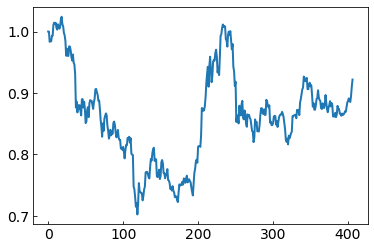

In [235]:
plt.plot(np.arange(netvalues.size), netvalues)

In [236]:
def gain(arr, interval=5, goal=0.06, frac=1., m=20., start=0):
    ii = start
    g = 0.
    share = 0.
    cap = 0.
    v = 0.
    tot_g = 0.
    tot_cap = 0.
    tot_v = 0.
    sold_times = 0
    while (ii<arr.size):
        if(arr[ii]<=0.):
            raise
        if(g > goal):
            #print("Sold at", ii, ".")
            sold_times += 1
            share -= share*frac
            #print("Share now: ", share)
            tot_cap += cap*frac
            tot_v += v*frac
            if(tot_cap==0.):
                tot_g = 0.
            else:
                tot_g = tot_v/tot_cap-1.
            cap = cap*(1.-frac)
            v = v*(1.-frac)
            if(cap==0.):
                g = 0.
            else:
                g = (v-cap)/cap
            #print("Total: ", tot_cap, tot_v, tot_g)
        share += m/arr[ii]
        cap += m
        v = share*arr[ii]
        if(cap==0.):
            g = 0.
        else:
            g = (v-cap)/cap
        #print("Share: ", share)

        ii += interval
    print("remaining cap: ", cap)
    tot_cap += cap
    tot_v += v
    if(tot_cap==0.):
        tot_g = 0.
    else:
        tot_g = tot_v/tot_cap-1. 
    print("remaining frac: ", cap/tot_cap)
    print("sold_times: ", sold_times)
    return tot_g, tot_cap, sold_times, cap/tot_cap


In [237]:
tg, tc, st, fc = gain(netvalues, interval=1, start=0)

remaining cap:  3480.0
remaining frac:  0.4275184275184275
sold_times:  2


In [238]:
print(tg, tc, tc*tg)

0.055425684245 8140.0 451.165069755


In [225]:
dim = 99
goal_list = np.linspace(0.03, 0.13, dim)
print(goal_list)
tg_arr = np.zeros(dim)
fc_arr = np.zeros(dim)
st_arr = np.zeros(dim)
tc_arr = np.zeros(dim)
ii = 0
for goalc in goal_list:
    tg, tc, st, fc = gain(netvalues, interval=5, goal=goalc, start=0)
    tg_arr[ii] = tg
    st_arr[ii] = st
    fc_arr[ii] = fc
    tc_arr[ii] = tc
    ii+=1

[ 0.03        0.03102041  0.03204082  0.03306122  0.03408163  0.03510204
  0.03612245  0.03714286  0.03816327  0.03918367  0.04020408  0.04122449
  0.0422449   0.04326531  0.04428571  0.04530612  0.04632653  0.04734694
  0.04836735  0.04938776  0.05040816  0.05142857  0.05244898  0.05346939
  0.0544898   0.0555102   0.05653061  0.05755102  0.05857143  0.05959184
  0.06061224  0.06163265  0.06265306  0.06367347  0.06469388  0.06571429
  0.06673469  0.0677551   0.06877551  0.06979592  0.07081633  0.07183673
  0.07285714  0.07387755  0.07489796  0.07591837  0.07693878  0.07795918
  0.07897959  0.08        0.08102041  0.08204082  0.08306122  0.08408163
  0.08510204  0.08612245  0.08714286  0.08816327  0.08918367  0.09020408
  0.09122449  0.0922449   0.09326531  0.09428571  0.09530612  0.09632653
  0.09734694  0.09836735  0.09938776  0.10040816  0.10142857  0.10244898
  0.10346939  0.1044898   0.1055102   0.10653061  0.10755102  0.10857143
  0.10959184  0.11061224  0.11163265  0.11265306  0

remaining cap:  960.0
remaining frac:  0.06417112299465241
sold_times:  4
remaining cap:  960.0
remaining frac:  0.06417112299465241
sold_times:  4


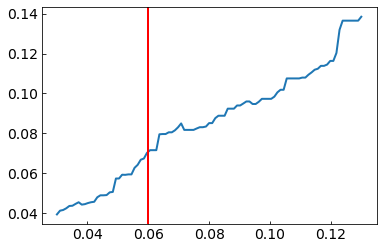

In [226]:
showingg = 0.06
plt.plot(goal_list, tg_arr)
plt.axvline(x=showingg,ymin=0.,ymax=8,c="r")

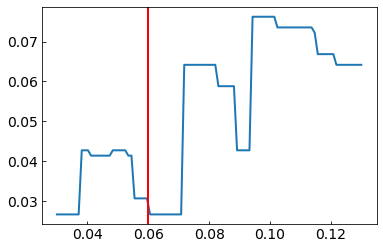

In [227]:
plt.plot(goal_list, fc_arr)
plt.axvline(x=showingg,ymin=0.,ymax=8,c="r")

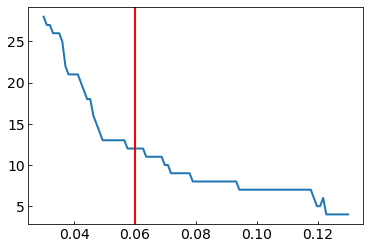

In [228]:
plt.plot(goal_list, st_arr)
plt.axvline(x=showingg,ymin=0.,ymax=8,c="r")

In [229]:
dim = 99
frac_list = np.linspace(0.25, 1., dim)
print(frac_list)
tg_arr = np.zeros(dim)
fc_arr = np.zeros(dim)
st_arr = np.zeros(dim)
tc_arr = np.zeros(dim)
ii = 0
for fracc in frac_list:
    tg, tc, st, fc = gain(netvalues, interval=1, goal=0.06, frac=fracc, start=0)
    tg_arr[ii] = tg
    st_arr[ii] = st
    fc_arr[ii] = fc
    tc_arr[ii] = tc
    ii+=1

[ 0.25        0.25765306  0.26530612  0.27295918  0.28061224  0.28826531
  0.29591837  0.30357143  0.31122449  0.31887755  0.32653061  0.33418367
  0.34183673  0.3494898   0.35714286  0.36479592  0.37244898  0.38010204
  0.3877551   0.39540816  0.40306122  0.41071429  0.41836735  0.42602041
  0.43367347  0.44132653  0.44897959  0.45663265  0.46428571  0.47193878
  0.47959184  0.4872449   0.49489796  0.50255102  0.51020408  0.51785714
  0.5255102   0.53316327  0.54081633  0.54846939  0.55612245  0.56377551
  0.57142857  0.57908163  0.58673469  0.59438776  0.60204082  0.60969388
  0.61734694  0.625       0.63265306  0.64030612  0.64795918  0.65561224
  0.66326531  0.67091837  0.67857143  0.68622449  0.69387755  0.70153061
  0.70918367  0.71683673  0.7244898   0.73214286  0.73979592  0.74744898
  0.75510204  0.7627551   0.77040816  0.77806122  0.78571429  0.79336735
  0.80102041  0.80867347  0.81632653  0.82397959  0.83163265  0.83928571
  0.84693878  0.85459184  0.8622449   0.86989796  0

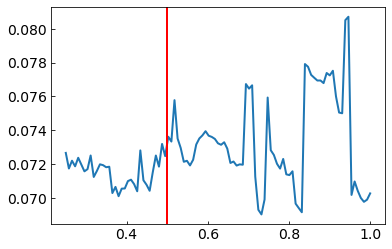

In [230]:
showingg = 0.5
plt.plot(frac_list, tg_arr)
plt.axvline(x=showingg,ymin=0.,ymax=8,c="r")

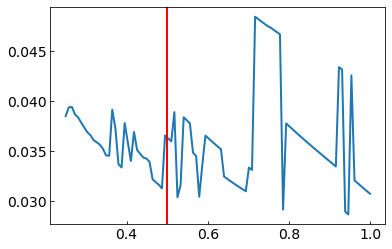

In [231]:
plt.plot(frac_list, fc_arr)
plt.axvline(x=showingg,ymin=0.,ymax=8,c="r")

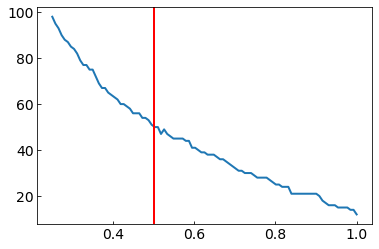

In [232]:
plt.plot(frac_list, st_arr)
plt.axvline(x=showingg,ymin=0.,ymax=8,c="r")

# for 300

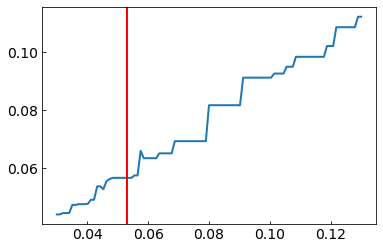

In [82]:
plt.plot(goal_list, tg_arr)
plt.axvline(x=0.053,ymin=0.,ymax=8,c="r")

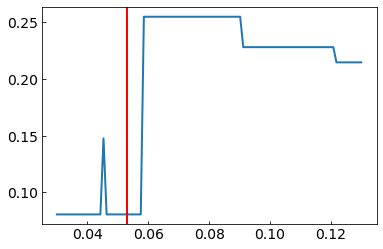

In [83]:
plt.plot(goal_list, fc_arr)
plt.axvline(x=0.053,ymin=0.,ymax=8,c="r")

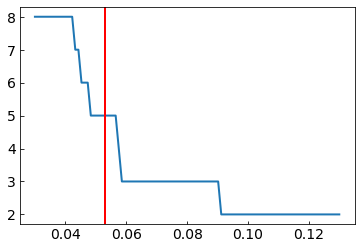

In [86]:
plt.plot(goal_list, st_arr)
plt.axvline(x=0.053,ymin=0.,ymax=8,c="r")